# Overview

### Description
Bloom Filters are a space-efficient data structure designed for querying if an element is present in a set. It returns either possibly in set or definitely not in set (i.e. false positives are possible but not false negatives). 

It requires an array of size m and k hash functions. The proportionality of k to m determines the false positive rate.

It has no maximum size, however the false positive rate increases as the number of elements it contains increases until it reaches 100%.

### Adding Elements
The element is passed through all of the k hash functions. Increment all of the outputted k array positions by 1. If the array position has reached the maximum value, do not change it.

### Deleting Elements
The element is passed through all of the k hash functions. If the key is present, decrement all of the outputted k array positions by 1.

### Querying Elements
The element is passed through all of the k hash functions. If any of the outputted k array positions consist of 0, the element is definitely not in set. If all the k array positions are 1, the element may be in set or it may be a false positive. 

### Applications
**Storing autofill information in a client side cache.**

This is a task that depends on time efficient adding and querying, else it defeats the purpose of avoiding communication with server. Any data structure used on cache would need to be very space efficient as it is client-side. And a low rate of false positives are tolerable and would require user recognition and intervention as false positives would not incurr any critical costs.

**Filtering where any fitting candidate is sufficient**

When there is an abundance of elements and a perfect element is not necessary, CBF could be a space and time efficient filtering mechanism with minimal impact on task performance. For example, for filtering on social media, shopping or dating sites.

# Implementation

I implemented the CBF class using three hash functions using three different methods: a division method, a multiplication method, and a randomization method. I chose these methods as they all produce uniformly distributed results and are distinct from each other. Thus, reducing the rate of collisions.

In [14]:
import random
import mmh3

class CBF():
    """
    Object implementation of Counting Bloom Filter
    """
    
    def __init__(self,m,k):
        # ensure valid inputs
        if m < 1 or k < 1:
            raise ValueError('Size of table and num hash funcs must be positive.')
        # set attributes
        self.k = k # number of hashes
        self.m = m # size of table
        self.n = 0 # initialize count to 0
        # create empty table
        self.table = [0 for _ in range(0,self.m)]
    
    def _getArrayPos(self, key):
        # get all array positions associated with the elem
        posList = []
        for i in range(1,self.k,1):
            posList.append((hash(key) + i * mmh3.hash(key)) % self.m)
        return posList
    
    def add(self, elem):
        # add element into table
        
        # update table
        for i in self._getArrayPos(elem):
            self.table[pos] += 1
        # update size
        self.n += 1
        
    def delete(self, elem):
        # remove element from table
        
        # update table
        for pos in self._getArrayPos(elem):
            self.table[pos] -= 1
        # update size
        self.n -= 1
        
    def query(self,elem):
        # check if elem in table
        for pos in self._getArrayPos(elem):
            if self.table[pos] <= 0:
                return False
        return True

In [15]:
mmh3.hash(78)

TypeError: a bytes-like object is required, not 'int'

# Testing

In [16]:
table = CBF(10000,5)

for i in range(1000):
    table.add(i)

TypeError: a bytes-like object is required, not 'int'

In [3]:
# ensuring no false negatives

for i in range(1000):
    if not table.query(i):
        raise ValueError('should be true!')
print('all good')

NameError: name 'table' is not defined

In [199]:
# sanity checking false positive rate:

import math
def theoereticalFP(n,m,k):
    return (1-math.exp(-k*n/m))**k

def empiricalFP(table,falseElems):
    fpRate = 0
    for elem in falseElems:
        if table.query(elem):
            fpRate += 1
    return(fpRate/len(falseElems))

falseElems = [i for i in range(1000,100000,1)]

print('FALSE POSITIVE RATE')
print('Theoretical: ',theoereticalFP(1000,10000,3))
print('Empirical: ',empiricalFP(table,falseElems))

FALSE POSITIVE RATE
Theoretical:  0.017410586496326586
Empirical:  0.9817575757575757


# Performance

### Memory Size as a Function of False Positive Rate

Holding number of items stored constant

**Theoretical**

Assuming that a hash function selects each array position with equal probability (i.e. $1/m$), then the probability that a position remains unset is ($1-1/m$). 

Given that we use $k$ hash functions per insertion, the probability that a position remains unset after one insertion is $(1-1/m)^k$.

Given n number of insertions, the probability that a position is unset is $(1-1/m)^{kn}$.

Thus, the probability that a position is set after n insertions is $1-(1-1/m)^{kn}$.

Thus of getting a positive return on querying the presence of an element that is not present is $((1-1/m)^{kn})^k$.

Thus, false positive rate as a function of memory size is approximately $(1-e^{-kn/m})^k$.

Thus, false positive rate and memory size should have a inversely exponential relationship (logarithmic).

In [106]:
import matplotlib.pyplot as plt

t_FpMem = []
for memsize in range(10,10000):
    t_FpMem.append(theoereticalFP(1000,memsize,3))

**Empirical**

In [100]:
falseElems = [i for i in range(1000,100000,1)]

e_FpMem = []
for memsize in range(10,10000,1000):
    table = CBF(memsize)
    for i in range(1000):
        table.add(i)
    e_FpMem.append(empiricalFP(table,falseElems))

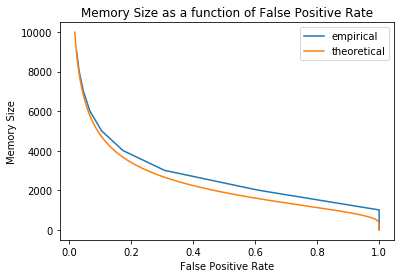

In [126]:
empX = [i for i in range(10,10000,1000)]
tX = [i for i in range(len(t_FpMem))]
plt.plot(e_FpMem, empX, label="empirical")
plt.plot(e_FpMem, empX, label="empirical")
plt.plot(t_FpMem,tX, label="theoretical")
plt.title('Memory Size as a function of False Positive Rate');
plt.ylabel('Memory Size');
plt.xlabel('False Positive Rate');
plt.legend();
plt.show;

The plot does indeed show logarithmic decay in memory size as false positive rate increases

**Overall**

Both theoretical and empirical methods suggest that memory size decays logarithmicly relative to the false positive rate (holding the number of items stored constant). Thus their relationship is $O(-lgn)$.

### Memory Size as a Function of Number of Items Stored
Now holding False Positive Rate at 2%

Given the above derived equation that $falsePositiveRate = (1-e^{-kn/m})^k$.

In order to hold a stable positive rate, memory size should then scale proportionally to the number of items stored since the ratio of the two is what affects the fales positive rate.

In [134]:
# get memory size theoretically

def getMem(n,p):
    return math.ceil((n * math.log(p)) / math.log(1 / pow(2, math.log(2))))

t_memN = []
for i in range(1,1000):
    t_memN.append(getMem(i,0.02))

In [ ]:
plt.plot(t_memN);
plt.title("Theoretical Memory Size as a Function of Number of Items Stored to maintain FP rate")
plt.xlabel("Number of Items Stored")
plt.ylabel("Memory Size")

**Empirical**

Since false positive rate is an output and mem size/ number of items stored are both inputs, the most efficient way to test this empirically is to test if the false positive rate does indeed stay constant for the theoretical mem size/ num of items stored pairs we calculated theoretically.

In [145]:
falseElems = [i for i in range(1000,100000,1)]

e_memN = []
for i in range(10,1000,10):
    table = CBF(t_memN[i])
    for x in range(i):
        table.add(x)
    e_memN.append(empiricalFP(table,falseElems))

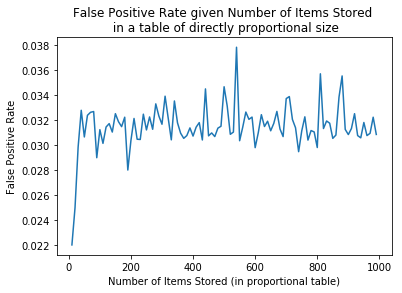

In [152]:
numItems = [i for i in range(10,1000,10)]
plt.plot(numItems,e_memN)
plt.title('False Positive Rate given Number of Items Stored \n in a table of directly proportional size');
plt.xlabel('Number of Items Stored (in proportional table)');
plt.ylabel('False Positive Rate');




Thus since the false positive rate is indeed fairly stable given pairs of proportional number of items and table size, we can conclude that if we hold the false positive rate steady, memory size is linearly related to the false positive rate.

**Overall**

Both theoretical and empirical methods suggest that memory size is directly proportional to the number of items stored (holding the false positive rate constant). Thus their relationship is $O(n)$, linear.

Of course, if we do not hold the false positive rate constant, then the number of items stored can scale indefinitely with fixed memory size (you would just have a 100% false positive rate past a certain point, which defeats the purpose).

### Access Time as a Function of the False Positive Rate

**Theoretical**

Access Time is not related to the false positive rate and hence will be constant $O(1)$.

The way that the data structure is designed and the algorithm for access makes it so that access time is always constant and is not dependent on any other factors.

**Empirical**

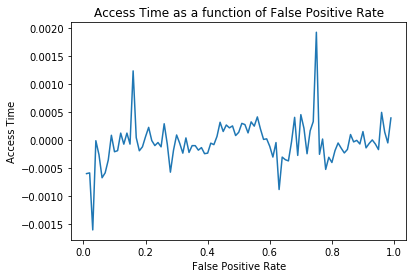

In [164]:
import timeit
# create tables of diff false positive rates by varying memory
# holding number of stored items fixed

# calculate memories of the tables
memForAt = []
for i in range(1,100):
    memForAt.append(getMem(100,i/100))

accessTimes_fp = []
# create the tables and log access time
for i in memForAt:
    table = CBF(i)
    for x in range(100):
        table.add(x)
    start = timeit.timeit()
    table.query(random.randint(0,100))
    end = timeit.timeit()
    accessTimes_fp.append(end-start)

fpRate = [i/100 for i in range(1,100)]
plt.plot(fpRate,accessTimes_fp);
plt.title("Access Time as a function of False Positive Rate");
plt.xlabel("False Positive Rate");
plt.ylabel("Access Time");

Thus we can see that access time remains almost 0 for any false positive rate. From this we can conclude that not only is access time constant relative to false positive rate, but it is also practically instantaneous.

### Access Time as a Function of Number of Items Stored

**Theoretical**

Again access Time is not related to the number of items stored and hence will be constant $O(1)$.

The way that the data structure is designed and the algorithm for access makes it so that access time is always constant and is not dependent on any other factors.

**Empirical**

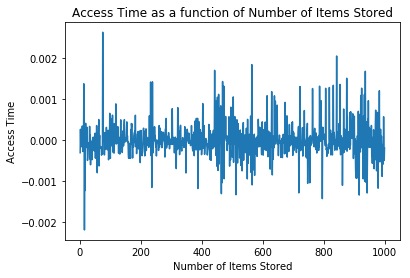

In [168]:
# create the tables and log access time
accessTimes_n = []
for i in range(1,1000):
    table = CBF(1000)
    for x in range(i):
        table.add(x)
    start = timeit.timeit()
    table.query(random.randint(0,i))
    end = timeit.timeit()
    accessTimes_n.append(end-start)

num = [i for i in range(1,1000)]
plt.plot(num,accessTimes_n);
plt.title("Access Time as a function of Number of Items Stored");
plt.xlabel("Number of Items Stored");
plt.ylabel("Access Time");

Again, we can see that access time remains almost 0 for any number of items stored. From this we can conclude that not only is access time constant relative to false positive rate, but it is also practically instantaneous.

# Implementation Vs Theoretical False Positive Rate

In [204]:
# theoretical
theoretical_FP = []
for i in range(100,1000,100):
    theoretical_FP.append(theoereticalFP(i,1000,3))

# empirical
falseElems = [i for i in range(2000,3000,10)]
empirical_FP = []
for i in range(100,1000,100):
    table = CBF(1000)
    for x in range (i):
        table.add(x)
        empirical_FP.append(empiricalFP(table,falseElems))

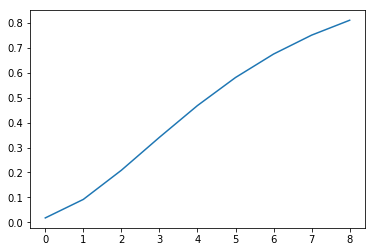

In [205]:
plt.plot(theoretical_FP)

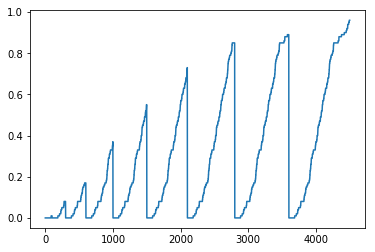

In [206]:
plt.plot(empirical_FP)

In [ ]:
# empirical
falseElems = [i for i in range(2000,3000,10)]
empirical_FP = []
for i in range(100,1000,100):
    table = CBF(1000)
    for x in range (i):
        table.add(x)
        empirical_FP.append(empiricalFP(table,falseElems))